In [ ]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
2
NVIDIA GeForce RTX 3080
NVIDIA GeForce RTX 3060


In [1]:
from utils import *

def analyze_json_responses(my_path):
    data = read_json(my_path)  # Legge il file JSON

    total_examples = len(data)  # Numero totale di esempi
    correct_with_context = 0  # Risposte corrette con risposta nel contesto
    correct_without_context = 0  # Risposte corrette senza risposta nel contesto
    has_answer_in_context = 0  # Esempi con risposta nel contesto
    no_answer_in_context = 0  # Esempi senza risposta nel contesto
    total_correct = 0  # Totale delle risposte corrette

    for entry in data:
        ans_in_documents = entry.get("ans_in_documents", False)
        ans_match_after_norm = entry.get("ans_match_after_norm", False)

        if ans_in_documents:
            has_answer_in_context += 1
            if ans_match_after_norm:
                correct_with_context += 1
        else:
            no_answer_in_context += 1
            if ans_match_after_norm:
                correct_without_context += 1

        # Conta ogni risposta corretta
        if ans_match_after_norm:
            total_correct += 1

    # Calcola le medie
    avg_correct_with_context = correct_with_context / has_answer_in_context if has_answer_in_context > 0 else 0
    avg_correct_without_context = correct_without_context / no_answer_in_context if no_answer_in_context > 0 else 0
    overall_accuracy = total_correct / total_examples if total_examples > 0 else 0

    return {
        "total_examples": total_examples,
        "examples_with_answer_in_context": has_answer_in_context,
        "examples_without_answer_in_context": no_answer_in_context,
        "correct_with_context": correct_with_context,
        "correct_without_context": correct_without_context,
        "average_correct_with_context": avg_correct_with_context,
        "average_correct_without_context": avg_correct_without_context,
        "overall_accuracy": overall_accuracy
    }


# Esempio di utilizzo
path = r'C:\Users\franc\Documents\Bridge_the_GAP\data\gen_res_example_llm\nq\gemma-2-2b-it\test\retrieved\contriever\5_doc\numdoc5_retr5_template_info_all_extended.json'
result = analyze_json_responses(path)
print(result)

{'total_examples': 2889, 'examples_with_answer_in_context': 1483, 'examples_without_answer_in_context': 1406, 'correct_with_context': 718, 'correct_without_context': 25, 'average_correct_with_context': 0.48415374241402565, 'average_correct_without_context': 0.017780938833570414, 'overall_accuracy': 0.25718241606092074}


Vedere l'accuracy dell'LLM passando i 5 Doc retrivati nei casi in comune con la risposta nel contesto.

In [9]:
from utils import *

def compare_json_data(gen_bgm, gen_only_llm):
    """
    Confronta due liste di dati JSON, trova gli esempi comuni con ans_in_documents=True in entrambi i dataset
    e calcola l'accuracy per entrambi basandosi su ans_match_after_norm.

    Args:
        gen_bgm (list): Lista di dizionari JSON dal primo file (con BGM).
        gen_only_llm (list): Lista di dizionari JSON dal secondo file (solo LLM).

    Returns:
        tuple: (lista di esempi comuni, accuracy_gen_bgm, accuracy_gen_only_llm)
    """
    # Convertire in dizionari per ricerca veloce
    gen_bgm_dict = {entry["example_id"]: entry for entry in gen_bgm}
    gen_only_llm_dict = {entry["example_id"]: entry for entry in gen_only_llm}

    # Trovare gli example_id in comune che hanno ans_in_documents=True in entrambi i dataset
    common_ids = {
        example_id for example_id in gen_bgm_dict.keys() & gen_only_llm_dict.keys()
        if gen_bgm_dict[example_id].get("ans_in_documents") is True and 
           gen_only_llm_dict[example_id].get("ans_in_documents") is True
    }

    # Filtrare gli esempi in comune con ans_in_documents=True
    common_examples = [gen_bgm_dict[example_id] for example_id in common_ids]

    # Funzione per calcolare l'accuracy basata su ans_match_after_norm
    def calculate_accuracy(dataset):
        correct = sum(1 for example_id in common_ids if dataset[example_id].get("ans_match_after_norm", False))
        total = len(common_ids)
        return correct / total if total > 0 else 0

    # Calcolare l'accuracy per entrambi i dataset
    accuracy_gen_bgm = calculate_accuracy(gen_bgm_dict)
    accuracy_gen_only_llm = calculate_accuracy(gen_only_llm_dict)

    return common_examples, accuracy_gen_bgm, accuracy_gen_only_llm


# Esempio di utilizzo con la tua funzione read_json
gen_bgm = read_json(r"C:\Users\franc\Documents\Bridge_the_GAP\data\gen_res_example_llm_with_bgm\steps_1800\nq\gemma-2-2b-it\test\retrieved\contriever\5_doc\numdoc5_retr5_template_info_all_extended.json")
gen_only_llm = read_json(r"C:\Users\franc\Documents\Bridge_the_GAP\data\gen_res_example_llm\nq\gemma-2-2b-it\test\retrieved\contriever\5_doc\numdoc5_retr5_template_info_all_extended.json")

common_data, accuracy_bgm, accuracy_llm = compare_json_data(gen_bgm, gen_only_llm)

# Stampare i risultati
print(f"Esempi comuni con ans_in_documents=True in entrambi i dataset: {len(common_data)}")
print(f"Accuracy (gen_bgm): {accuracy_bgm:.4%}")
print(f"Accuracy (gen_only_llm): {accuracy_llm:.4%}")

Esempi comuni con ans_in_documents=True in entrambi i dataset: 520
Accuracy (gen_bgm): 60.3846%
Accuracy (gen_only_llm): 55.3846%


In [3]:
from utils import *
import re
from collections import Counter

def analyze_gen_bgm_stats(gen_bgm):
    """
    Analizza il file gen_bgm e calcola le statistiche sui documenti passati 
    e quante volte almeno un documento è rilevante in ogni categoria.

    Args:
        gen_bgm (list): Lista di dizionari JSON dal file gen_bgm.

    Returns:
        dict: Dizionario con statistiche sui documenti passati e sulla rilevanza.
    """
    doc_count_distribution = Counter()
    relevant_doc_count_distribution = Counter()  # Quante volte almeno un doc è rilevante in ogni caso

    for example in gen_bgm:
        # Estrarre gli ID dei documenti, escludendo quelli nel formato "Unknown(Id_X)"
        bgm_indices = example.get("bgm_indices", "").split(",")
        valid_doc_ids = [doc for doc in bgm_indices if not re.match(r"Unknown\(Id_\d+\)", doc)]

        num_valid_docs = len(valid_doc_ids)  # Conta solo i documenti validi
        doc_count_distribution[num_valid_docs] += 1  # Conta quante volte troviamo N documenti

        # Verificare se almeno un documento passato è rilevante
        if example.get("ans_in_documents", False):
            relevant_doc_count_distribution[num_valid_docs] += 1  # Conta nei casi con doc rilevanti

    # Costruzione del risultato finale
    stats = {
        "num_examples_no_docs": doc_count_distribution[0],  # Nessun documento passato
        "num_examples_1_doc": doc_count_distribution[1],  # Esattamente 1 documento passato
        "num_examples_2_docs": doc_count_distribution[2],
        "num_examples_3_docs": doc_count_distribution[3],
        "num_examples_4_docs": doc_count_distribution[4],
        "num_examples_5_docs": doc_count_distribution[5],  # Esattamente 5 documenti passati
        "num_examples_with_relevant_doc": sum(relevant_doc_count_distribution.values()),  # Totale esempi con almeno 1 doc rilevante
        "relevant_docs_per_case": {  # Quante volte almeno un doc è rilevante in ogni categoria
            "0_docs": relevant_doc_count_distribution[0],
            "1_doc": relevant_doc_count_distribution[1],
            "2_docs": relevant_doc_count_distribution[2],
            "3_docs": relevant_doc_count_distribution[3],
            "4_docs": relevant_doc_count_distribution[4],
            "5_docs": relevant_doc_count_distribution[5],
        },
        "total_examples": len(gen_bgm)  # Numero totale di esempi analizzati
    }

    return stats


# Esempio di utilizzo con la tua funzione read_json
gen_bgm = read_json(r"C:\Users\franc\Documents\Bridge_the_GAP\data\gen_res_example_llm_with_bgm\steps_1800\nq\gemma-2-2b-it\test\retrieved\contriever\5_doc\numdoc5_retr5_template_info_all_extended.json")

# Ottenere le statistiche
stats = analyze_gen_bgm_stats(gen_bgm)

# Stampare i risultati
print("Statistiche sui documenti passati nel file gen_bgm:")
for key, value in stats.items():
    if key == "relevant_docs_per_case":
        print("\nQuante volte almeno un documento rilevante è presente nei vari casi:")
        for sub_key, sub_value in value.items():
            print(f"{sub_key}: {sub_value}")
    else:
        print(f"{key}: {value}")


Statistiche sui documenti passati nel file gen_bgm:
num_examples_no_docs: 0
num_examples_1_doc: 11
num_examples_2_docs: 6
num_examples_3_docs: 2855
num_examples_4_docs: 15
num_examples_5_docs: 0
num_examples_with_relevant_doc: 520

Quante volte almeno un documento rilevante è presente nei vari casi:
0_docs: 0
1_doc: 2
2_docs: 0
3_docs: 517
4_docs: 1
5_docs: 0
total_examples: 2889


Controlla quanti esempi ha la generazione dei migliori indici con il 600 esimo steps del training

Per analizzare il file JSON generato e contare quanti esempi rientrano nelle varie categorie in base al numero di ID presenti in bgm_indices

In [7]:
import json
import re
from collections import Counter

def analyze_bgm_indices(file_path):
    """
    Analizza il file JSON della generazione dei migliori indici con il 600° step del training.
    Conta quanti esempi hanno 1,2,3,4,5 ID in bgm_indices e quanti non ne hanno trovati,
    escludendo gli ID che contengono 'Unknown()' o 'Unknown("")'.
    Inoltre, controlla se nel prompt è presente una delle risposte nel campo "answers",
    considerando solo il contenuto dopo "Documents:" e associandolo alla categoria di documenti trovati.

    Args:
        file_path (str): Percorso del file JSON.

    Returns:
        dict: Statistiche sul numero di ID in bgm_indices e presenza di risposte nel prompt.
    """
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Conta quante volte troviamo 0, 1, 2, 3, 4, 5 ID
    bgm_counts = Counter()
    answer_in_prompt_counts = Counter()

    for example in data:
        bgm_indices = example.get("bgm_indices", "")
        prompt = example.get("prompt", "").lower()
        answers = [ans.lower() for ans in example.get("answers", [])]
        
        # Estrarre solo la parte dopo "Documents:" se presente
        if "documents:" in prompt:
            prompt = prompt.split("documents:", 1)[-1]
        else:
            prompt = ""  # Se non c'è "Documents:", significa che non ci sono documenti

        # Controlla se una delle risposte è presente nel prompt
        answer_in_prompt = any(answer in prompt for answer in answers) if prompt else False

        # Se non ha trovato nessun ID buono
        if bgm_indices in ["NO_DOCS", "Unknown("")"]:
            bgm_counts[0] += 1
            if answer_in_prompt:
                answer_in_prompt_counts[0] += 1
        else:
            # Dividere gli ID separati da ","
            ids = [id_.strip() for id_ in bgm_indices.split(",") if id_.strip()]

            # Escludere gli ID che contengono "Unknown()" o "Unknown('')"
            valid_ids = [id_ for id_ in ids if not re.match(r"Unknown\(.*\)", id_)]

            # Conta quanti ID validi ci sono
            num_valid_ids = len(valid_ids)

            # Se non rimangono ID validi, conta come 0 documenti
            bgm_counts[num_valid_ids] += 1
            if answer_in_prompt:
                answer_in_prompt_counts[num_valid_ids] += 1

    # Creazione delle statistiche
    stats = {
        "num_examples_0_docs": bgm_counts[0],  # Nessun ID trovato
        "num_examples_1_doc": bgm_counts[1],  # 1 ID in bgm_indices
        "num_examples_2_docs": bgm_counts[2],  # 2 ID
        "num_examples_3_docs": bgm_counts[3],  # 3 ID
        "num_examples_4_docs": bgm_counts[4],  # 4 ID
        "num_examples_5_docs": bgm_counts[5],  # 5 ID
        "total_examples": len(data),  # Numero totale di esempi analizzati
        "num_examples_with_answer_in_prompt_0_docs": answer_in_prompt_counts[0],
        "num_examples_with_answer_in_prompt_1_doc": answer_in_prompt_counts[1],
        "num_examples_with_answer_in_prompt_2_docs": answer_in_prompt_counts[2],
        "num_examples_with_answer_in_prompt_3_docs": answer_in_prompt_counts[3],
        "num_examples_with_answer_in_prompt_4_docs": answer_in_prompt_counts[4],
        "num_examples_with_answer_in_prompt_5_docs": answer_in_prompt_counts[5],
    }

    return stats

# Percorso del file JSON
file_path = r"C:\Users\franc\Documents\Bridge_the_GAP\data\gen_best_ids_doc_test_set_according_bgm\nq\gemma-2-2b-it\test\retrieved\contriever\5_doc\numdoc5_retr5_template_bgm_training_epoch1600_info.json"

# Analizza il file JSON e ottieni le statistiche
stats = analyze_bgm_indices(file_path)

# Stampare i risultati
print("Statistiche sugli ID in bgm_indices:")
for key, value in stats.items():
    print(f"{key}: {value}")

Statistiche sugli ID in bgm_indices:
num_examples_0_docs: 287
num_examples_1_doc: 1
num_examples_2_docs: 1500
num_examples_3_docs: 1101
num_examples_4_docs: 0
num_examples_5_docs: 0
total_examples: 2889
num_examples_with_answer_in_prompt_0_docs: 0
num_examples_with_answer_in_prompt_1_doc: 0
num_examples_with_answer_in_prompt_2_docs: 420
num_examples_with_answer_in_prompt_3_docs: 411
num_examples_with_answer_in_prompt_4_docs: 0
num_examples_with_answer_in_prompt_5_docs: 0


In [6]:
import os
import argparse
import warnings
import pandas as pd
import re
from tqdm import tqdm
from typing import Tuple, Dict, Optional

import torch
from torch.utils.data import DataLoader
from transformers import PreTrainedTokenizer

from utils import *
from bgm import BGM
from default_prompts import *
from prompt_dataset import PromptDataset

os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings('ignore')
SEED=10

info = {
    "nq_bgm": {
        "train": {
            "data_path": r'C:\Users\franc\Documents\Bridge_the_GAP\data\10k_train_dataset.json',
            "contriever_search_results_path": r"C:\Users\franc\Documents\Bridge_the_GAP\data\processed\contriever_search_results_at150.pkl",
        }
    },
}

def save_dataloader_to_json(dataloader, output_file, num_examples=15):
    all_batches = []

    print("Saving DataLoader contents to JSON...")
    for idx, batch in enumerate(dataloader):
        if idx >= num_examples:  # Stop after saving the specified number of examples
            break

        batch_dict = {}
        for key, value in batch.items():
            # Convert tensors to lists for JSON serialization
            if isinstance(value, torch.Tensor):
                batch_dict[key] = value.tolist()
            else:
                batch_dict[key] = value
        all_batches.append(batch_dict)
    
    # Save the entire list of dictionaries to a JSON file
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(all_batches, f, ensure_ascii=False, indent=4)

    print(f"DataLoader contents saved to {output_file}")

class DotDict:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

def parse_arguments(custom_args=None):
    """
    Mimics argparse to parse arguments for LLM generation. Accepts custom arguments as a dictionary for notebooks.
    """
    # Define default values
    default_args = {
        'output_dir': r'C:\Users\franc\Documents\Bridge_the_GAP\data\gen_id_document_bgm',
        'llm_id': 'google/flan-t5-large',
        'dataset': 'nq_bgm',
        'model_max_length': 4096,
        'quantization_bits': 4,
        'use_model_chat_template': False, 
        'gold_position': None,
        'num_retrieved_documents': 5,
        'use_test': False,
        'max_new_tokens': 50,
        'use_task_with_proof': False,
        'batch_size': None,
        'save_every': 250,
    }

    # If custom_args is provided, update defaults
    if custom_args:
        default_args.update(custom_args)

    # Perform validation
    if default_args['num_retrieved_documents'] is None:
        raise ValueError("'num_retrieved_documents' must be specified.")
    if default_args['num_retrieved_documents'] <= 0:
        raise ValueError("'num_retrieved_documents' must be a positive integer.")
    if default_args['gold_position'] is not None:
        if (default_args['gold_position'] < 0 or 
            default_args['gold_position'] >= default_args['num_retrieved_documents']):
            raise ValueError("'gold_position' must be within the range of 'num_retrieved_documents'.")

    return DotDict(**default_args)


def load_corpus(
    args: argparse.Namespace
) -> Tuple[List[Dict], Optional[Dict[int, int]]]:
    
    # Corpus with documents from Contriever
    corpus, full_to_subset_idx_map = read_corpus_with_contriever()

    return corpus, full_to_subset_idx_map

def load_search_results(args: argparse.Namespace) -> List[Tuple[List[int], List[float]]]:

    search_results_path = info[args.dataset][args.split]['contriever_search_results_path']
    retriever_search_results = read_pickle(search_results_path)

    return retriever_search_results


def get_prompt_template(args: argparse.Namespace):
    prompt_configuration = args.dataset
    if args.use_model_chat_template:
        chat_task_template_str = chat_task_templates[args.llm_id]['template']
        
        task_instruction = task_instructions[prompt_configuration]

        prompt_template = apply_chat_task_template(chat_task_template_str, task_instruction)
    else:
        task_template = task_templates[prompt_configuration]

        prompt_template = task_template.create_prompt_template()

    return prompt_template


def initialize_dataset_and_loader(
    args: argparse.Namespace, 
    corpus: List[Dict], 
    full_to_subset_idx_map: Optional[Dict[int, int]], 
    retriever_search_results: List[Tuple[List[int], List[float]]], 
    tokenizer: PreTrainedTokenizer
) -> DataLoader:
    
    prompt_template = get_prompt_template(args)
    
    prompt_ds = PromptDataset(
        corpus=corpus, data_path=info[args.dataset][args.split]['data_path'], 
        tokenizer=tokenizer, 
        max_tokenized_length=args.model_max_length - 2, 
        search_results=retriever_search_results,
        prompt_template=prompt_template,
        full_to_subset_idx_map=full_to_subset_idx_map,
        do_normalize_query=True, 
        num_documents_in_context=args.num_retrieved_documents,
        gold_position=args.gold_position, # None in these experiments
    )
        
    prompt_dataloader = DataLoader(
        prompt_ds,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )
    return prompt_dataloader


def print_info(args: argparse.Namespace):
    print("INFO:")    
    print(f"DATA: {info[args.dataset][args.split]['data_path']}")
    print(f"USE TEST: {args.use_test}")
    print(f"MODEL: {args.llm_id}")
    print(f"MODEL MAX LENGTH: {args.model_max_length}")
    print(f'MAX NEW TOKENS: {args.max_new_tokens}')
    print(f"USE MODEL CHAT TEMPLATE: {args.use_model_chat_template}")
    print(f"TASK WITH PROOF:", args.use_task_with_proof)
    print(f"GOLD POSITION: {args.gold_position}")
    print(f"NUM DOCUMENTS IN CONTEXT: {args.num_retrieved_documents}")
    print(f"BATCH SIZE: {args.batch_size}")
    print(f"SAVE EVERY: {args.save_every}")


def extract_generate_answers(
    args: argparse.Namespace, 
    generated_output: List[str]
) -> List[str]:
    answer_prefix = "Answer:"
    if args.use_model_chat_template:
        answer_prefix = re.escape(chat_task_templates[args.llm_id]['answer_prefix'])

    generated_answers = []
    for output in generated_output:
        matches = list(re.finditer(answer_prefix, output))
        match_idx = 0

        # When using the proof there is a one-shot example that already 
        # contains the string "Answer:". Thus, we should get the second (match_idx=1) match.
        if args.use_model_chat_template and answer_prefix != "Answer:":
            match_idx = 0
 
        answer_end = matches[match_idx].end()
        response = output[answer_end:].strip()
        generated_answers.append(response)
    
    return generated_answers


def BGMTraining(
    args: argparse.Namespace, 
    prompt_ds: PromptDataset,
    llm: BGM, 
    prompt_dataloader: DataLoader
):
    # Info from arguments
    llm_id = args.llm_id
    num_doc = args.num_retrieved_documents
    save_every = args.save_every
    retriever_str = "contriever" 
    chat_template_str = "_template" if args.use_model_chat_template else ""
    prompt_type = "retrieved_proof" if args.use_task_with_proof else "retrieved"

    # Create the saving directory
    llm_folder = llm_id.split("/")[1] if '/' in llm_id else llm_id
    saving_dir = f"{args.output_dir}/{args.dataset}/{llm_folder}/{args.split}/{prompt_type}/{retriever_str}/{num_doc}_doc"
    os.makedirs(saving_dir, exist_ok=True)

    all_info = []  
    for idx, prompt_batch in enumerate(tqdm(prompt_dataloader)):
        prompts = prompt_batch['prompt']
        example_id = prompt_batch['example_id']
        prompts = prompt_batch['prompt']
        query = prompt_batch['query']
        document_indices=prompt_batch['document_indices']
        
        for doc_idx in document_indices:
            
            candidate_docs += doc_idx

            formatted_docs, _ = prompt_ds._get_documents_from_indices(candidate_docs)

            if '\nAnswer:' not in candidate_prompt:
                candidate_prompt += '\nAnswer:'

            

        generated_output = llm.generate(
            prompts, 
            max_new_tokens=args.max_new_tokens
        )

        generated_answers = extract_generate_answers(args, generated_output)
        prompt_batch['generated_answer'] = generated_answers
        
        all_info.append(prompt_batch)
        '''
        if (idx + 1) % save_every == 0 or (idx + 1) == len(prompt_dataloader):
            print(f"Saving at {idx + 1}...")
            file_name = f"{saving_dir}/numdoc{num_doc}_retr{args.num_retrieved_documents}{chat_template_str}_info_{idx+1}.pkl"
            write_pickle(all_info, file_name)
            all_info = []
        '''


def main():
    args = parse_arguments()

    args.split = "test" if args.use_test else "train"

    print("Loading LLM...")
    llm_id = args.llm_id
    bgm = BGM(
        llm_id, device,  
        model_max_length=args.model_max_length
    )
    tokenizer = bgm.tokenizer
    print("LLM loaded")


    print("Loading corpus and search results...")
    corpus, full_to_subset_idx_map = load_corpus(args)
    retriever_search_results = load_search_results(args)
    print("Corpus and search results loaded")


    print("Loading prompt dataset...")
    prompt_ds, prompt_dataloader = initialize_dataset_and_loader(
        args, corpus, full_to_subset_idx_map, 
        retriever_search_results, tokenizer
    )
    print("Prompt dataset loaded")

    print_info(args)

    #output_json_path = r'C:\Users\franc\Documents\Bridge_the_GAP\data\dataloader_contents.json'
    #save_dataloader_to_json(prompt_dataloader, output_json_path, num_examples=15)
        
    BGMTraining(args, prompt_ds, bgm, prompt_dataloader)



if __name__ == "__main__":
    seed_everything(SEED)
    main()

Loading LLM...
LLM loaded
Loading corpus and search results...
Corpus and search results loaded
Loading prompt dataset...
Prompt dataset loaded
INFO:
DATA: C:\Users\franc\Documents\Bridge_the_GAP\data\10k_train_dataset.json
USE TEST: False
MODEL: google/flan-t5-large
MODEL MAX LENGTH: 4096
MAX NEW TOKENS: 50
USE MODEL CHAT TEMPLATE: False
TASK WITH PROOF: False
GOLD POSITION: None
NUM DOCUMENTS IN CONTEXT: 3
BATCH SIZE: None
SAVE EVERY: 250
Saving DataLoader contents to JSON...
DataLoader contents saved to C:\Users\franc\Documents\Bridge_the_GAP\data\dataloader_contents.json


In [ ]:
import json

def match_example_ids(file1_path, file2_path, output_path):
    """
    Modifica il file1 aggiungendo l'example_id da file2 quando query e question corrispondono.

    Args:
        file1_path (str): Percorso al file JSON di input 1.
        file2_path (str): Percorso al file JSON di input 2.
        output_path (str): Percorso al file JSON di output aggiornato.
    """
    try:
        # Caricamento dei file JSON
        with open(file1_path, 'r') as f1:
            file1 = json.load(f1)

        with open(file2_path, 'r') as f2:
            file2 = json.load(f2)

        # Creazione di un dizionario per mappare le domande agli example_id
        question_to_example_id = {item['question']: item['example_id'] for item in file2}

        # Modifica del primo file
        for entry in file1:
            query = entry.get('query')
            if query in question_to_example_id:
                entry['example_id'] = question_to_example_id[query]

        # Salvataggio del file aggiornato
        with open(output_path, 'w') as f1_updated:
            json.dump(file1, f1_updated, indent=4)

        print(f"File aggiornato salvato in: {output_path}")
    except FileNotFoundError as e:
        print(f"Errore: {e}")
    except json.JSONDecodeError as e:
        print(f"Errore nel parsing del file JSON: {e}")
    except Exception as e:
        print(f"Errore imprevisto: {e}")

def update_queries_with_document_indices(file1_path, file2_path, output_path):
    # Carica i dati dai file JSON
    with open(file1_path, 'r', encoding='utf-8') as f1, open(file2_path, 'r', encoding='utf-8') as f2:
        file1_data = json.load(f1)
        file2_data = json.load(f2)

    # Crea un dizionario per mappare le query ai document_indices di File 2
    query_to_indices = {
        entry['query']: entry.get('document_indices', [])
        for entry in file2_data
    }

    # Aggiorna File 1 aggiungendo i document_indices associati alle query
    for entry in file1_data:
        query = entry['query']
        if query in query_to_indices:
            entry['document_indices'] = query_to_indices[query]

    # Salva il risultato in un nuovo file JSON
    with open(output_path, 'w', encoding='utf-8') as output_file:
        json.dump(file1_data, output_file, indent=4, ensure_ascii=False)


path_output=r'C:\Users\franc\Documents\Bridge_the_GAP\data\gen_ids_document_training_set_bgm\nq_training\gemma-2-2b-it\train\retrieved\contriever\5_doc\numdoc5_retr5_template_info_all_extended_updated.json'
file_da_modificare = r'C:\Users\franc\Documents\Bridge_the_GAP\data\gen_ids_document_training_set_bgm\nq_training\gemma-2-2b-it\train\retrieved\contriever\5_doc\numdoc5_retr5_template_info_all_extended.json'
file_di_confronto = r'C:\Users\franc\Documents\Bridge_the_GAP\data\10k_train_dataset.json'

match_example_ids(file_da_modificare, file_di_confronto, path_output)

update_queries_with_document_indices(r'C:\Users\franc\Documents\Bridge_the_GAP\data\gen_ids_document_training_set_bgm\nq_training\gemma-2-2b-it\train\retrieved\contriever\5_doc\numdoc5_retr5_template_info_all_extended_updated.json', r'C:\Users\franc\Documents\Bridge_the_GAP\data\gen_ids_document_training_set_bgm\nq_training\gemma-2-2b-it\train\retrieved\contriever\5_doc\numdoc5_retr5_template_info_all_extended_updated.json', r'C:\Users\franc\Documents\Bridge_the_GAP\data\gen_ids_document_training_set_bgm\nq_training\gemma-2-2b-it\train\retrieved\contriever\5_doc\numdoc5_retr5_template_info_all_extended_updated_last.json')

File aggiornato salvato in: C:\Users\franc\Documents\Bridge_the_GAP\data\gen_ids_document_training_set_bgm\nq_training\gemma-2-2b-it\train\retrieved\contriever\5_doc\numdoc5_retr5_template_info_all_extended_updated.json


In [11]:
import json
import random

# Percentuali per ogni caso
percentages = {
    "case_1_single_doc": 0.1,
    "case_2_multiple_docs": 0.2,
    "case_3_no_docs": 0.1,
    "case_4_less_docs": 0.4,
    "case_5_reranking": 0.2,
}

# Task instruction da aggiungere a ogni query
task_instruction = "Output only the document IDs relevant to the query. Use this format: [ID1, ID2, ...]."

def process_data(input_file, output_file):
    with open(input_file, "r", encoding="utf-8") as f:
        examples = json.load(f)

    dataset = []
    
    # Shuffle examples to ensure random sampling
    random.shuffle(examples)

    # Total examples to be processed for each case
    total_examples = len(examples)
    case_limits = {case: int(total_examples * perc) for case, perc in percentages.items()}
    case_counters = {case: 0 for case in percentages}

    for example in examples:
        if all(count >= case_limits[case] for case, count in case_counters.items()):
            break  # Stop if all case limits are met
        
        query = f"Task Instruction: {task_instruction}\nQuestion:{example['query']}"  # Aggiunge la task instruction
        retrieved_docs = example["document_indices"]
        selected_docs = example["selected_documents"]
        are_answer = example["are_answer"]

        # Case 1: Single document correct answer
        if are_answer and len(selected_docs) == 1 and case_counters["case_1_single_doc"] < case_limits["case_1_single_doc"]:
            dataset.append({
                "input": {
                    "query": query,
                    "retrieved_docs": retrieved_docs,
                },
                "output": selected_docs,
            })
            case_counters["case_1_single_doc"] += 1

        # Case 2: Multiple documents correct answer
        elif are_answer and len(selected_docs) > 1 and case_counters["case_2_multiple_docs"] < case_limits["case_2_multiple_docs"]:
            dataset.append({
                "input": {
                    "query": query,
                    "retrieved_docs": retrieved_docs,
                },
                "output": selected_docs,
            })
            case_counters["case_2_multiple_docs"] += 1

        # Case 3: No documents correct answer
        elif are_answer and len(selected_docs) == 0 and case_counters["case_3_no_docs"] < case_limits["case_3_no_docs"]:
            dataset.append({
                "input": {
                    "query": query,
                    "retrieved_docs": [],
                },
                "output": [],
            })
            case_counters["case_3_no_docs"] += 1

        # Case 4: Input and output unchanged
        elif are_answer and len(selected_docs) > 2 and case_counters["case_4_less_docs"] < case_limits["case_4_less_docs"]:
            dataset.append({
                "input": {
                    "query": query,
                    "retrieved_docs": selected_docs,
                },
                "output": selected_docs,
            })
            case_counters["case_4_less_docs"] += 1

        # Case 5: Reranking
        elif are_answer and len(selected_docs) > 2 and case_counters["case_5_reranking"] < case_limits["case_5_reranking"]:
            reranked_docs = random.sample(selected_docs, len(selected_docs))  # Randomize order
            dataset.append({
                "input": {
                    "query": query,
                    "retrieved_docs": reranked_docs,
                },
                "output": selected_docs,
            })
            case_counters["case_5_reranking"] += 1

    # Save the dataset to a file
    with open(output_file, "w") as f:
        json.dump(dataset, f, indent=4)

# Path to input and output files
input_file = r'C:\Users\franc\Documents\Bridge_the_GAP\data\gen_ids_document_training_set_bgm\nq_training\gemma-2-2b-it\train\retrieved\contriever\5_doc\numdoc5_retr5_info_all_extended_training_set.json'
output_file = r'C:\Users\franc\Documents\Bridge_the_GAP\data\training_dataset.json'

process_data(input_file, output_file)

In [ ]:
import json
import random

# Percentuali per ogni caso
percentages = {
    "case_1_single_doc": 0.07,
    "case_2_multiple_docs": 0.4,
    "case_3_no_docs": 0.1,
    "case_4_multi_doc_unchanged": 0.35,
    "case_5_reranking": 0.5,
    "case_6_single_doc_unchanged": 0.05,
}

# Task instruction da aggiungere a ogni query
task_instruction = "Output only the document IDs relevant to the query. Use this format: [ID1, ID2, ...]."

def process_data(input_file, output_file):
    with open(input_file, "r", encoding="utf-8") as f:
        examples = json.load(f)

    # Filtra gli esempi con are_answer = true
    valid_examples = [ex for ex in examples if ex["are_answer"] is True]

    print(f"Totale esempi nel file di input: {len(examples)}")
    print(f"Esempi con 'are_answer=True': {len(valid_examples)}")

    # Raggruppa per numero di selected_documents
    grouped_examples = {
        "len_0": [ex for ex in valid_examples if len(ex["selected_documents"]) == 0],
        "len_1": [ex for ex in valid_examples if len(ex["selected_documents"]) == 1],
        "len_gt_1": [ex for ex in valid_examples if len(ex["selected_documents"]) > 1],
    }

    print(f"Esempi con 'selected_documents == 0': {len(grouped_examples['len_0'])}")
    print(f"Esempi con 'selected_documents == 1': {len(grouped_examples['len_1'])}")
    print(f"Esempi con 'selected_documents > 1': {len(grouped_examples['len_gt_1'])}")

    # Calcola le suddivisioni per ogni gruppo
    group_case_limits = {
        "case_1_single_doc": int(len(grouped_examples["len_1"]) * percentages["case_1_single_doc"]),
        "case_2_multiple_docs": int(len(grouped_examples["len_gt_1"]) * percentages["case_2_multiple_docs"]),
        "case_3_no_docs": int(len(grouped_examples["len_0"]) * percentages["case_3_no_docs"]),
        "case_4_multi_doc_unchanged": int(len(grouped_examples["len_gt_1"]) * percentages["case_4_multi_doc_unchanged"]),
        "case_5_reranking": int(len(grouped_examples["len_gt_1"]) * percentages["case_5_reranking"]),
        "case_6_single_doc_unchanged": int(len(grouped_examples["len_1"]) * percentages["case_6_single_doc_unchanged"]),
    }

    print("Distribuzione pianificata degli esempi nel dataset creato:")
    for case, limit in group_case_limits.items():
        print(f"{case}: {limit}")

    dataset = []
    case_counters = {case: 0 for case in group_case_limits}

    # Processa gli esempi
    for example in valid_examples:
        query = f"Task Instruction: {task_instruction}\nQuestion:{example['query']}"
        retrieved_docs = example["document_indices"]
        selected_docs = example["selected_documents"]

        # Case 1: Single document correct answer
        if len(selected_docs) == 1 and case_counters["case_1_single_doc"] < group_case_limits["case_1_single_doc"]:
            dataset.append({
                "input": {
                    "query": query,
                    "retrieved_docs": retrieved_docs,
                },
                "output": selected_docs,
            })
            case_counters["case_1_single_doc"] += 1

        # Case 2: Multiple documents correct answer
        elif len(selected_docs) > 1 and case_counters["case_2_multiple_docs"] < group_case_limits["case_2_multiple_docs"]:
            dataset.append({
                "input": {
                    "query": query,
                    "retrieved_docs": retrieved_docs,
                },
                "output": selected_docs,
            })
            case_counters["case_2_multiple_docs"] += 1

        # Case 3: No documents correct answer
        elif len(selected_docs) == 0 and case_counters["case_3_no_docs"] < group_case_limits["case_3_no_docs"]:
            dataset.append({
                "input": {
                    "query": query,
                    "retrieved_docs": [],
                },
                "output": [],
            })
            case_counters["case_3_no_docs"] += 1

        # Case 4: Input and output unchanged for multiple docs
        elif len(selected_docs) > 1 and case_counters["case_4_multi_doc_unchanged"] < group_case_limits["case_4_multi_doc_unchanged"]:
            dataset.append({
                "input": {
                    "query": query,
                    "retrieved_docs": selected_docs,
                },
                "output": selected_docs,
            })
            case_counters["case_4_multi_doc_unchanged"] += 1

        # Case 6: Input and output unchanged for single doc
        elif len(selected_docs) == 1 and case_counters["case_6_single_doc_unchanged"] < group_case_limits["case_6_single_doc_unchanged"]:
            dataset.append({
                "input": {
                    "query": query,
                    "retrieved_docs": selected_docs,
                },
                "output": selected_docs,
            })
            case_counters["case_6_single_doc_unchanged"] += 1

        # Case 5: Reranking
        elif len(selected_docs) > 1 and case_counters["case_5_reranking"] < group_case_limits["case_5_reranking"]:
            reranked_docs = selected_docs[:]
            while reranked_docs == selected_docs:  # Garantisce che l'ordine sia diverso
                reranked_docs = random.sample(selected_docs, len(selected_docs))
            dataset.append({
                "input": {
                    "query": query,
                    "retrieved_docs": reranked_docs,
                },
                "output": selected_docs,
            })
            case_counters["case_5_reranking"] += 1

    print("Esempi effettivamente inclusi nel dataset creato:")
    tot=0
    for case, count in case_counters.items():
        tot += count
        print(f"{case}: {count}")

    print(f"Totale degli Esempi inclusi nel training dataset creato: {tot}")
    

    # Save the dataset to a file
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(dataset, f, indent=4)

# Path to input and output files
input_file = r'C:\Users\franc\Documents\Bridge_the_GAP\data\gen_best_ids_document_training_set_bgm\nq_training\gemma-2-2b-it\train\retrieved\contriever\5_doc\numdoc5_retr5_info_all_extended_training_set.json'
output_file = r'C:\Users\franc\Documents\Bridge_the_GAP\data\training_dataset.json'

process_data(input_file, output_file)

Totale esempi nel file di input: 3000
Esempi con 'are_answer=True': 1233
Esempi con 'selected_documents == 0': 366
Esempi con 'selected_documents == 1': 736
Esempi con 'selected_documents > 1': 131
Distribuzione pianificata degli esempi nel dataset creato:
case_1_single_doc: 51
case_2_multiple_docs: 52
case_3_no_docs: 36
case_4_multi_doc_unchanged: 45
case_5_reranking: 65
case_6_single_doc_unchanged: 36
Esempi effettivamente inclusi nel dataset creato:
case_1_single_doc: 51
case_2_multiple_docs: 52
case_3_no_docs: 36
case_4_multi_doc_unchanged: 45
case_5_reranking: 34
case_6_single_doc_unchanged: 36
Totale degli Esempi inclusi nel training dataset creato: 254


In [ ]:
import os
import re 
import argparse
import warnings
from tqdm import tqdm
from typing import Tuple, Dict, Optional, Union, List

import torch
from torch.utils.data import DataLoader
from transformers import PreTrainedTokenizer, AutoModelForCausalLM
from trl import setup_chat_format

from utils import *
from bgm import BGM
from llm import LLM
from default_prompts import *
from prompt_dataset import PromptDataset
from datasets import Dataset

os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings('ignore')
SEED=10

info = {
    "nq": {
        "test": {
            "data_path": r'C:\Users\franc\Documents\Bridge_the_GAP\data\test_dataset.json',
            "contriever_search_results_path": r"C:\Users\franc\Documents\Bridge_the_GAP\data\processed\contriever_test_search_results_at150.pkl",
        }
    },
}

class DotDict:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

def parse_arguments(custom_args=None):
    """
    Mimics argparse to parse arguments for LLM generation. Accepts custom arguments as a dictionary for notebooks.
    """
    # Define default values
    default_args = {
        'output_dir': r'C:\Users\franc\Documents\Bridge_the_GAP\data\gen_res_example_llm_with_bgm',
        'bgm_id': 'meta-llama/Llama-3.2-1B',
        'llm_id': 'google/gemma-2-2b-it',
        'dataset': 'nq',
        'task_instruction' : "Output only the document IDs relevant to the query. Use this format: [Id_1, Id_2, ...].",
        'model_max_length': 4096,
        'quantization_bits': 4,
        'gold_position': None,
        'use_model_chat_template': False, 
        'num_retrieved_documents': 5,
        'use_test': True,
        'padding_strategy': 'longest',
        'max_new_tokens': 50,
        'use_task_with_proof': False,
        'batch_size': None,
        'save_every': 250,
    }

    # If custom_args is provided, update defaults
    if custom_args:
        default_args.update(custom_args)

    # Perform validation
    if default_args['num_retrieved_documents'] is None:
        raise ValueError("'num_retrieved_documents' must be specified.")
    if default_args['num_retrieved_documents'] <= 0:
        raise ValueError("'num_retrieved_documents' must be a positive integer.")
    if default_args['gold_position'] is not None:
        if (default_args['gold_position'] < 0 or 
            default_args['gold_position'] >= default_args['num_retrieved_documents']):
            raise ValueError("'gold_position' must be within the range of 'num_retrieved_documents'.")

    return DotDict(**default_args)


def load_corpus(
    args: argparse.Namespace
) -> Tuple[List[Dict], Optional[Dict[int, int]]]:
    
    # Corpus with documents from Contriever
    corpus, full_to_subset_idx_map = read_test_corpus_with_random_and_contriever()

    return corpus, full_to_subset_idx_map

def load_search_results(args: argparse.Namespace) -> List[Tuple[List[int], List[float]]]:

    search_results_path = info[args.dataset][args.split]['contriever_search_results_path']
    retriever_search_results = read_pickle(search_results_path)

    return retriever_search_results


def get_prompt_template(args: argparse.Namespace):
    prompt_configuration = args.dataset
    if args.use_model_chat_template:
        chat_task_template_str = chat_task_templates[args.llm_id]['template']
        
        task_instruction = task_instructions[prompt_configuration]

        prompt_template = apply_chat_task_template(chat_task_template_str, task_instruction)
    else:
        task_template = task_templates[prompt_configuration]

        prompt_template = task_template.create_prompt_template()

    return prompt_template

def process_dataset(dataset, task_instruction):
    """
    Processes the dataset by applying the chat template transformation.

    Args:
        dataset (List[Dict]): The dataset to be processed.

    Returns:
        List[Dict]: The processed dataset with formatted text.
    """

    # Define the chat messages format
    messages = [
        {"role": "system", "content": task_instruction},
        {"role": "user", "content": dataset},
    ]

    return messages

def initialize_dataset_and_loader(
    args: argparse.Namespace, 
    corpus: List[Dict], 
    full_to_subset_idx_map: Optional[Dict[int, int]], 
    retriever_search_results: List[Tuple[List[int], List[float]]], 
    tokenizer: PreTrainedTokenizer,
) -> DataLoader:
    
    prompt_template = get_prompt_template(args)
    
    prompt_ds = PromptDataset(
        corpus=corpus, data_path=info[args.dataset][args.split]['data_path'], 
        tokenizer=tokenizer, 
        max_tokenized_length=args.model_max_length - 2, 
        search_results=retriever_search_results,
        prompt_template=prompt_template,
        full_to_subset_idx_map=full_to_subset_idx_map,
        do_normalize_query=True, 
        num_documents_in_context=args.num_retrieved_documents,
        gold_position=args.gold_position, # None in these experiments
    )
        
    prompt_dataloader = DataLoader(
        prompt_ds,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )
    return prompt_dataloader

    
def map_document_indices(prompt: str, document_indices: list) -> tuple:
    """
    Modifica il prompt mappando i document ID originali con ID sequenziali.
    
    Args:
        prompt (str): Il prompt originale contenente i document ID.
        document_indices (list): Lista degli indici dei documenti nel prompt.

    Returns:
        tuple: Il prompt modificato e la mappatura (original_id -> new_id).
    """
    id_mapping = {}
    
    # Mappa i document ID ai nuovi ID sequenziali (Id_1, Id_2, ...)
    for idx, doc_id in enumerate(document_indices, start=1):
        new_id = f"Id_{idx}"
        id_mapping[str(doc_id)] = new_id
    
    # Sostituisce i document ID nel prompt
    modified_prompt = prompt
    for original_id, new_id in id_mapping.items():
        modified_prompt = re.sub(rf'\[{original_id}\]', f'[{new_id}]', modified_prompt)
    
    return modified_prompt, id_mapping

def extract_and_convert_answer_indices(generated_output: str, id_mapping: dict) -> str:
    """
    Estrae e converte gli ID generati dal modello dopo '<|im_start|>assistant'.
    Converte gli ID nel formato originale. Se non trova un ID nella mappatura, restituisce 'Unknown(ID)'.

    Args:
        generated_output (str): Testo con la risposta generata dal modello.
        id_mapping (dict): Mappatura {original_id: Id_n}.

    Returns:
        str: Stringa con gli ID originali separati da virgola.
    """
    # Invertire la mappatura per ottenere {Id_n: original_id}
    inverse_mapping = {v: k for k, v in id_mapping.items()}

    # Estrae la risposta dopo '<|im_start|>assistant'
    match = re.search(r'<\|im_start\|>assistant\s*(.*)', generated_output, re.DOTALL)
    if not match:
        return "Nessuna risposta trovata"
    #if match:
        #print("Contenuto dopo assistant:", repr(match.group(1)))

    # Ottieni la stringa con gli ID dopo assistant
    answer_string = match.group(1).strip().split("<|im_end|>")[0].strip()

    # Dividi e converte gli ID
    generated_ids = [id_.strip() for id_ in answer_string.split(",") if id_.strip()]
    original_ids = [inverse_mapping.get(id_, f"Unknown({id_})") for id_ in generated_ids]

    # Restituisci gli ID originali come stringa separata da virgole
    return ",".join(original_ids)

def reconstruct_prompt_from_ids(
    original_ids: str,
    prompt: str,
    task_instruction: str = "You are given a question and you must respond based on the provided documents. You must always provide an answer."
) -> str:
    """
    Ricostruisce il prompt originale utilizzando solo i documenti selezionati dal modello,
    ignorando gli ID non presenti nella lista generale.

    Args:
        original_ids (str): Stringa contenente gli ID separati da virgola (es. "628506,3546609").
        prompt (str): Testo completo del prompt originale.

    Returns:
        str: Il prompt ricostruito contenente solo i documenti selezionati.
    """
    query_match = re.search(r"Question:\s*(.*?)(?=Document|\Z)", prompt, re.DOTALL)
    query = query_match.group(1).strip() if query_match else "Query non trovata"

    #print(f"Query originale trovata: {query}")
    
    documents = re.findall(
        r"(Document \[(\d+)\]\(.*?\)\s.*?)(?=Document \[\d+\]|$)", 
        prompt, 
        re.DOTALL
    )
    documents_dict = {doc_id.strip(): full_text.strip() for full_text, doc_id in documents}

    print(f"ID disponibili nel prompt: {list(documents_dict.keys())}")

    selected_ids = [id_.strip() for id_ in original_ids.split(",") if id_.strip()]
    
    valid_ids = [id_ for id_ in selected_ids if id_ in documents_dict]

    print(f"ID validi generati dal modello: {valid_ids}")

    selected_documents = [
        re.sub(r'Answer:\s*\n?', '', documents_dict[id_]) 
        for id_ in valid_ids
    ]

    if not selected_documents:
        return #nesun documento trovato

    reconstructed_prompt = "\n".join(selected_documents)

    final_prompt = (f"{task_instruction}\nQuestion: {query}\nDocuments:\n{reconstructed_prompt}\nAnswer:")

    final_prompt = re.sub(r'\n+', '\n', final_prompt).strip()

    return final_prompt

def extract_generate_answers(
    args: argparse.Namespace, 
    generated_output: List[str]
) -> List[str]:
    answer_prefix = "Answer:"
    if args.use_model_chat_template:
        answer_prefix = re.escape(chat_task_templates[args.llm_id]['answer_prefix'])

    generated_answers = []
    for output in generated_output:
        matches = list(re.finditer(answer_prefix, output))
        match_idx = 0

        # When using the proof there is a one-shot example that already 
        # contains the string "Answer:". Thus, we should get the second (match_idx=1) match.
        if args.use_task_with_proof:
            match_idx = 1
            if args.use_model_chat_template and answer_prefix != "Answer:":
                match_idx = 0
 
        answer_end = matches[match_idx].end()
        response = output[answer_end:].strip()
        generated_answers.append(response)
    
    return generated_answers

def print_info(args: argparse.Namespace):
    print("INFO:")    
    print(f"DATA: {info[args.dataset]['test']['data_path']}")
    print(f"TASK INSTRUCTION: {args.task_instruction}")
    print(f"USE TEST: {args.use_test}")
    print(f"BGM MODEL: {args.bgm_id}")
    print(f"LLm MODEL: {args.llm_id}")
    print(f"MODEL MAX LENGTH: {args.model_max_length}")
    print(f'MAX NEW TOKENS: {args.max_new_tokens}')
    print(f"USE MODEL CHAT TEMPLATE: {args.use_model_chat_template}")
    print(f"TASK WITH PROOF:", args.use_task_with_proof)
    print(f"GOLD POSITION: {args.gold_position}")
    print(f"NUM DOCUMENTS IN CONTEXT: {args.num_retrieved_documents}")
    print(f"BATCH SIZE: {args.batch_size}")
    print(f"SAVE EVERY: {args.save_every}")


def generate_and_save(
    args: argparse.Namespace, 
    model_weights_path,
    llm: LLM, 
    tokenizer,
    dataset,
    num_examples=10,
    max_length=50
):
    
    llm_id = args.llm_id
    num_doc = args.num_retrieved_documents
    save_every = args.save_every
    retriever_str = "contriever"
    padding_str = f"_{args.padding_strategy}{args.model_max_length}" if args.padding_strategy != "longest" else "" 
    chat_template_str = "_template" if args.use_model_chat_template else ""
    prompt_type = "retrieved_proof" if args.use_task_with_proof else "retrieved"

    # Create the saving directory
    llm_folder = llm_id.split("/")[1] if '/' in llm_id else llm_id
    saving_dir = f"{args.output_dir}/{args.dataset}/{llm_folder}/{args.split}/{prompt_type}/{retriever_str}/{num_doc}_doc"
    #os.makedirs(saving_dir, exist_ok=True)

    # Load the trained model
    model = AutoModelForCausalLM.from_pretrained(model_weights_path)
    model.to(device)
    model.eval()

    all_info = []  
    for idx, prompt_batch in enumerate(tqdm(dataset)):
        if idx >= num_examples:
            break

        prompt = prompt_batch['prompt'].replace('You are given a question and you must respond based on the provided documents. You must always provide an answer.', "")
        document_indices= prompt_batch['document_indices']

        # Mappa i document ID nel prompt
        modified_prompt, id_mapping = map_document_indices(prompt, document_indices)
        print(f"Processing Example {idx+1}:\n")

        prompt_formatted = process_dataset(modified_prompt, args.task_instruction)
        prompt_formatted = tokenizer.apply_chat_template(
            prompt_formatted, tokenize=False, add_generation_prompt=False, add_special_tokens=False
        )

        # Tokenize the input
        inputs = tokenizer(prompt_formatted, return_tensors="pt", truncation=False).to(device)

        # Generate the model's response
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=max_length, num_beams=5)

        # Decode the generated response
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=False)

        # Convertire gli ID generati nei document ID originali
        original_ids = extract_and_convert_answer_indices(generated_text, id_mapping)

        filtered_prompt = reconstruct_prompt_from_ids(original_ids, prompt)
        print(filtered_prompt)

        generated_output = llm.generate(
            filtered_prompt,
            padding_strategy=args.padding_strategy, 
            max_new_tokens=args.max_new_tokens
        )

        generated_answers = extract_generate_answers(args, generated_output)
        print(f"La risposta generata dal modello e':\n{generated_answers}")
        prompt_batch['generated_answer'] = generated_answers
        all_info.append(prompt_batch)

        '''
        if (idx + 1) % save_every == 0 or (idx + 1) == len(dataset):
            print(f"Saving at {idx + 1}...")
            file_name = f"{saving_dir}/numdoc{num_doc}_retr{args.num_retrieved_documents}{padding_str}{chat_template_str}_info_{idx+1}.pkl"
            write_pickle(all_info, file_name)
            all_info = []
        '''
        

def main():
    args = parse_arguments()

    args.split = "test" if args.use_test else "train"

    print("Loading BGM...")
    bgm_id = args.bgm_id
    
    bgm = BGM(
        bgm_id, device, 
        quantization_bits=args.quantization_bits, 
        model_max_length=15,
    )
    bgm_model= bgm.model

    tokenizer = bgm.tokenizer
    model, tokenizer = setup_chat_format(bgm_model, tokenizer)
    print("BGM loaded")
    
    print("Loading LLM...")
    llm_id = args.llm_id
    llm = LLM(
        llm_id, device, 
        quantization_bits=args.quantization_bits, 
        model_max_length=args.model_max_length
    )
    print("LLM loaded")

    task_instruction = args.task_instruction

    print("Loading corpus and search results...")
    corpus, full_to_subset_idx_map = load_corpus(args)
    retriever_search_results = load_search_results(args)
    print("Corpus and search results loaded")


    print("Loading prompt dataset...")
    prompt_dataloader = initialize_dataset_and_loader(
        args, corpus, full_to_subset_idx_map, 
        retriever_search_results, tokenizer
    )
    print("Prompt dataset loaded")

    print_info(args)

    training_path=r'C:\Users\franc\Documents\Bridge_the_GAP\data\SFT_training_bgm\meta-llama-Llama-3.2-1B\checkpoint-800'  #best checkpoint 700-800
    generate_and_save(args, training_path, llm, tokenizer, prompt_dataloader, num_examples=10, max_length=15)



if __name__ == "__main__":
    seed_everything(SEED)
    main()

c:\Users\franc\Documents\Bridge_the_GAP\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BGM...


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


BGM loaded
Loading LLM...


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.08s/it]


LLM loaded
Loading corpus and search results...


Token indices sequence length is longer than the specified maximum sequence length for this model (778 > 15). Running this sequence through the model will result in indexing errors


Corpus and search results loaded
Loading prompt dataset...
Prompt dataset loaded
INFO:
DATA: C:\Users\franc\Documents\Bridge_the_GAP\data\test_dataset.json
TASK INSTRUCTION: Output only the document IDs relevant to the query. Use this format: [Id_1, Id_2, ...].
USE TEST: True
BGM MODEL: meta-llama/Llama-3.2-1B
LLm MODEL: google/gemma-2-2b-it
MODEL MAX LENGTH: 4096
MAX NEW TOKENS: 50
USE MODEL CHAT TEMPLATE: False
TASK WITH PROOF: False
GOLD POSITION: None
NUM DOCUMENTS IN CONTEXT: 5
BATCH SIZE: None
SAVE EVERY: 250


  0%|          | 0/2889 [00:00<?, ?it/s]

Processing Example 1:

ID disponibili nel prompt: ['628506', '3546609', '439756', '1860765', '2043329']
ID validi generati dal modello: ['628506', '2043329', '1860765']
You are given a question and you must respond based on the provided documents. You must always provide an answer.
Question:who got the first nobel prize in physics
Documents:
Document [628506](Title: Nobel Prize in Physics) receive a diploma, a medal and a document confirming the prize amount. Nobel Prize in Physics The Nobel Prize in Physics () is a yearly award given by the Royal Swedish Academy of Sciences for those who have made the most outstanding contributions for mankind in the field of physics. It is one of the five Nobel Prizes established by the will of Alfred Nobel in 1895 and awarded since 1901; the others being the Nobel Prize in Chemistry, Nobel Prize in Literature, Nobel Peace Prize, and Nobel Prize in Physiology or Medicine. The first Nobel Prize in Physics was
Document [2043329](Title: Universology) be

  0%|          | 1/2889 [01:57<94:29:59, 117.80s/it]

La risposta generata dal modello e':
['This document does not say who received the first Nobel Prize in Physics.']
Processing Example 2:



  0%|          | 1/2889 [02:54<139:47:25, 174.25s/it]


KeyboardInterrupt: 

In [8]:
import os
import re 
import argparse
import warnings
from tqdm import tqdm
from typing import Tuple, Dict, Optional, Union, List

import torch
from torch.utils.data import DataLoader
from transformers import PreTrainedTokenizer, AutoModelForCausalLM
from trl import setup_chat_format

from utils import *
from bgm import BGM
from llm import LLM
from default_prompts import *
from prompt_dataset import PromptDataset
from datasets import Dataset

os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings('ignore')
SEED=10

info = {
    "nq": {
        "test": {
            "data_path": r'C:\Users\franc\Documents\Bridge_the_GAP\data\test_dataset.json',
            "contriever_search_results_path": r"C:\Users\franc\Documents\Bridge_the_GAP\data\processed\contriever_test_search_results_at150.pkl",
        }
    },
}

class DotDict:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

def parse_arguments(custom_args=None):
    """
    Mimics argparse to parse arguments for LLM generation. Accepts custom arguments as a dictionary for notebooks.
    """
    # Define default values
    default_args = {
        'output_dir': r'C:\Users\franc\Documents\Bridge_the_GAP\data\gen_res_example_llm_with_bgm',
        'bgm_id': 'meta-llama/Llama-3.2-1B',
        'llm_id': 'google/gemma-2-2b-it',
        'dataset': 'nq',
        'task_instruction' : "Output only the IDs of the documents relevant to the query. Use this format: [Id_1, Id_2, ...]. If there is no relevant document, output NO_DOCS.",
        'model_max_length': 4096,
        'quantization_bits': 4,
        'gold_position': None,
        'use_model_chat_template': True, 
        'num_retrieved_documents': 5,
        'use_test': True,
        'padding_strategy': 'longest',
        'max_new_tokens': 50,
        'use_task_with_proof': False,
        'batch_size': None,
        'save_every': 250,
    }

    # If custom_args is provided, update defaults
    if custom_args:
        default_args.update(custom_args)

    # Perform validation
    if default_args['num_retrieved_documents'] is None:
        raise ValueError("'num_retrieved_documents' must be specified.")
    if default_args['num_retrieved_documents'] <= 0:
        raise ValueError("'num_retrieved_documents' must be a positive integer.")
    if default_args['gold_position'] is not None:
        if (default_args['gold_position'] < 0 or 
            default_args['gold_position'] >= default_args['num_retrieved_documents']):
            raise ValueError("'gold_position' must be within the range of 'num_retrieved_documents'.")

    return DotDict(**default_args)


def get_prompt_template(args: argparse.Namespace):
    prompt_configuration = args.dataset
    if args.use_model_chat_template:
        chat_task_template_str = chat_task_templates[args.llm_id]['template']
        
        task_instruction = task_instructions[prompt_configuration]

        prompt_template = apply_chat_task_template(chat_task_template_str, task_instruction)
    else:
        task_template = task_templates[prompt_configuration]

        prompt_template = task_template.create_prompt_template()

    return prompt_template


def extract_generate_answers(
    args: argparse.Namespace, 
    generated_output: List[str]
) -> List[str]:
    answer_prefix = "Answer:"
    if args.use_model_chat_template:
        answer_prefix = '\n\nmodel' #re.escape(chat_task_templates[args.llm_id]['answer_prefix'])

    generated_answers = []
    for output in generated_output:
        matches = list(re.finditer(answer_prefix, output))
        match_idx = 0

        # When using the proof there is a one-shot example that already 
        # contains the string "Answer:". Thus, we should get the second (match_idx=1) match.
        if args.use_task_with_proof:
            match_idx = 1
            if args.use_model_chat_template and answer_prefix != "Answer:":
                match_idx = 0
 
        answer_end = matches[match_idx].end()
        response = output[answer_end:].strip()
        generated_answers.append(response)
    
    return generated_answers

def print_info(args: argparse.Namespace):
    print("INFO:")    
    print(f"DATA: {info[args.dataset]['test']['data_path']}")
    print(f"TASK INSTRUCTION: {args.task_instruction}")
    print(f"USE TEST: {args.use_test}")
    print(f"BGM MODEL: {args.bgm_id}")
    print(f"LLM MODEL: {args.llm_id}")
    print(f"MODEL MAX LENGTH: {args.model_max_length}")
    print(f'MAX NEW TOKENS: {args.max_new_tokens}')
    print(f"USE MODEL CHAT TEMPLATE: {args.use_model_chat_template}")
    print(f"TASK WITH PROOF:", args.use_task_with_proof)
    print(f"GOLD POSITION: {args.gold_position}")
    print(f"NUM DOCUMENTS IN CONTEXT: {args.num_retrieved_documents}")
    print(f"BATCH SIZE: {args.batch_size}")
    print(f"SAVE EVERY: {args.save_every}")


def generate_and_save(
    args: argparse.Namespace, 
    steps_training: int,
    llm: LLM, 
    dataset_path,
    max_length=50
):
    
    dataset = read_json(dataset_path)
    
    llm_id = args.llm_id
    num_doc = args.num_retrieved_documents
    save_every = args.save_every
    retriever_str = "contriever"
    padding_str = f"_{args.padding_strategy}{args.model_max_length}" if args.padding_strategy != "longest" else "" 
    chat_template_str = "_template" if args.use_model_chat_template else ""
    prompt_type = "retrieved_proof" if args.use_task_with_proof else "retrieved"

    # Create the saving directory
    llm_folder = llm_id.split("/")[1] if '/' in llm_id else llm_id
    saving_dir = f"{args.output_dir}/steps_{steps_training}/{args.dataset}/{llm_folder}/{args.split}/{prompt_type}/{retriever_str}/{num_doc}_doc"
    os.makedirs(saving_dir, exist_ok=True)

    all_info = []
    for idx, prompt_batch in enumerate(tqdm(dataset)):
            
        prompt = prompt_batch['prompt'].replace('You are given a question and you must respond based on the provided documents. You must always provide an answer.', 'You are given a question and you must respond based on the provided documents. Respond directly without providing any premise or explanation. If none of the documents contain the answer, please respond with NO-RESPONSE. Do not try to respond based on your own knowledge.')

        generated_output = llm.generate(
            prompt,
            padding_strategy=args.padding_strategy, 
            max_new_tokens=args.max_new_tokens
        )
        
        generated_answers = extract_generate_answers(args, generated_output)

        prompt_batch['generated_answer'] = generated_answers
        prompt_batch['prompt'] = prompt

        all_info.append(prompt_batch)

        if (idx + 1) % save_every == 0 or (idx + 1) == len(dataset):
            print(f"Saving at {idx + 1}...")
            file_name = f"{saving_dir}/numdoc{num_doc}_retr{args.num_retrieved_documents}{padding_str}{chat_template_str}_info_{idx+1}.pkl"
            write_pickle(all_info, file_name)
            all_info = []
        

def main():
    args = parse_arguments()

    args.split = "test" if args.use_test else "train"
    
    print("Loading LLM...")
    llm_id = args.llm_id
    llm = LLM(
        llm_id, device, 
        quantization_bits=args.quantization_bits, 
        model_max_length=args.model_max_length
    )
    print("LLM loaded")

    print_info(args)

    dataset_path = r'C:\Users\franc\Documents\Bridge_the_GAP\data\gen_res_example_llm_with_bgm\old_task_instruction\steps_1800\nq\gemma-2-2b-it\test\retrieved\contriever\5_doc\numdoc5_retr5_template_info_all_extended.json'
    generate_and_save(args, 1800, llm, dataset_path, max_length=15)



if __name__ == "__main__":
    seed_everything(SEED)
    main()

Loading LLM...


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


LLM loaded
INFO:
DATA: C:\Users\franc\Documents\Bridge_the_GAP\data\test_dataset.json
TASK INSTRUCTION: Output only the IDs of the documents relevant to the query. Use this format: [Id_1, Id_2, ...]. If there is no relevant document, output NO_DOCS.
USE TEST: True
BGM MODEL: meta-llama/Llama-3.2-1B
LLM MODEL: google/gemma-2-2b-it
MODEL MAX LENGTH: 4096
MAX NEW TOKENS: 50
USE MODEL CHAT TEMPLATE: True
TASK WITH PROOF: False
GOLD POSITION: None
NUM DOCUMENTS IN CONTEXT: 5
BATCH SIZE: None
SAVE EVERY: 250


  9%|▊         | 250/2889 [03:36<31:35,  1.39it/s]  

Saving at 250...


 17%|█▋        | 500/2889 [07:07<27:59,  1.42it/s]  

Saving at 500...


 26%|██▌       | 750/2889 [10:25<24:56,  1.43it/s]  

Saving at 750...


 35%|███▍      | 1000/2889 [13:56<25:17,  1.24it/s] 

Saving at 1000...


 43%|████▎     | 1250/2889 [17:35<26:11,  1.04it/s]  

Saving at 1250...


 52%|█████▏    | 1500/2889 [21:05<42:57,  1.86s/it]

Saving at 1500...


 61%|██████    | 1750/2889 [24:49<14:08,  1.34it/s]

Saving at 1750...


 69%|██████▉   | 2000/2889 [28:12<09:41,  1.53it/s]

Saving at 2000...


 78%|███████▊  | 2250/2889 [31:28<08:39,  1.23it/s]

Saving at 2250...


 87%|████████▋ | 2500/2889 [34:57<06:13,  1.04it/s]

Saving at 2500...


 95%|█████████▌| 2750/2889 [38:16<01:48,  1.28it/s]

Saving at 2750...


100%|██████████| 2889/2889 [40:13<00:00,  1.20it/s]

Saving at 2889...


Risultati da inserire nella tesi

In [ ]:
import json

## CONSIDERA SOLO I CASI DI RISPOSTA VALIDA , NON CONSIDERANDO I CASI NO-RESPONSE
def trova_risposte_corrette_bgm_only(rag_bgm_file, llm_file, output_file):
    # Carica i dati dai due file JSON
    with open(rag_bgm_file, 'r') as f:
        rag_bgm_data = json.load(f)
    
    with open(llm_file, 'r') as f:
        llm_data = json.load(f)
    
    # Crea un dizionario per trovare facilmente gli ID esempio nel file LLM
    llm_examples = {example['example_id']: example for example in llm_data}
    
    # Lista per memorizzare gli ID degli esempi con risposta corretta solo in RAG + BGM
    correct_only_in_rag_bgm = []
    
    for example in rag_bgm_data:
        example_id = example['example_id']
        generated_answer_bgm = example['generated_answer']
        correct_bgm = example['is_correct']
        
        # Verifica che la risposta in RAG + BGM sia corretta, non sia "NO-RESPONSE" e sia presente nei documenti
        if correct_bgm and generated_answer_bgm != "NO-RESPONSE" and example['ans_in_documents']:
            # Controlla se esiste lo stesso esempio nel file LLM
            if example_id in llm_examples:
                # Ottieni l'esempio corrispondente nel file LLM
                llm_example = llm_examples[example_id]
                generated_answer_llm = llm_example['generated_answer']
                correct_llm = llm_example['is_correct']
                
                # Verifica che la risposta nel file LLM non sia corretta
                if not correct_llm:
                    correct_only_in_rag_bgm.append(example)
    
    # Salva i risultati in un nuovo file JSON
    with open(output_file, 'w') as f:
        json.dump(correct_only_in_rag_bgm, f, indent=4)
    
    return correct_only_in_rag_bgm

# Esempio di utilizzo
rag_bgm_file = r'C:\Users\franc\Documents\Bridge_the_GAP\data\gen_res_example_llm_with_bgm\steps_1800\nq\gemma-2-2b-it\test\retrieved\contriever\5_doc\numdoc5_retr5_template_info_all_extended.json'
llm_file = r'C:\Users\franc\Documents\Bridge_the_GAP\data\gen_res_example_llm\nq\gemma-2-2b-it\test\retrieved\contriever\5_doc\numdoc5_retr5_template_info_all_extended.json' 
output_file = r'C:\Users\franc\Documents\Bridge_the_GAP\data\results_for_the_thesis\risultati_rag+bgm_only_with_answer_in_context.json'

risultati = trova_risposte_corrette_bgm_only(rag_bgm_file, llm_file, output_file)
print(f"Trovati {len(risultati)} esempi con risposta corretta solo in RAG + BGM. I risultati sono stati salvati in {output_file}.")

Trovati 92 esempi con risposta corretta solo in RAG + BGM. I risultati sono stati salvati in C:\Users\franc\Documents\Bridge_the_GAP\data\results_for_the_thesis\risultati_rag_bgm_only.json.


In [9]:
import json

def trova_indici_in_ordine_diverso(input_file, output_file):
    # Carica i dati dal file di input (che è stato generato dalla funzione precedente)
    with open(input_file, 'r') as f:
        data = json.load(f)
    
    # Lista per memorizzare gli esempi che soddisfano la condizione
    examples_with_different_order = []
    
    for example in data:
        # Filtra gli indici "Unknown" sia da bgm_indices che da document_indices
        bgm_indices = [index for index in example['bgm_indices'].split(',') if not index.lower().startswith("unknown")]
        document_indices = [str(idx) for idx in example['document_indices']]  # Gli indici nei documenti sono già una lista
        
        # Verifica se l'ordine degli indici è diverso tra bgm_indices e document_indices
        if bgm_indices != document_indices:
            examples_with_different_order.append(example)
    
    # Salva i risultati in un nuovo file JSON
    with open(output_file, 'w') as f:
        json.dump(examples_with_different_order, f, indent=4)
    
    return examples_with_different_order

# Esempio di utilizzo
input_file = r'C:\Users\franc\Documents\Bridge_the_GAP\data\results_for_the_thesis\risultati_rag+bgm_only_with_answer_in_context.json'
output_file = r'C:\Users\franc\Documents\Bridge_the_GAP\data\results_for_the_thesis\risultati_rag+bgm_only_with_different_id_document_order.json'  

risultati = trova_indici_in_ordine_diverso(input_file, output_file)
print(f"Trovati {len(risultati)} esempi con indici BGM in ordine diverso rispetto agli indici dei documenti (ignorando 'Unknown'). I risultati sono stati salvati in {output_file}.")

Trovati 92 esempi con indici BGM in ordine diverso rispetto agli indici dei documenti (ignorando 'Unknown'). I risultati sono stati salvati in C:\Users\franc\Documents\Bridge_the_GAP\data\results_for_the_thesis\risultati_rag+bgm_only_with_different_id_document_order.json.


In [2]:
import json

def trova_risposte_NO_RESPONSE_utili(rag_bgm_file, llm_file, output_file):
    # Carica i dati dai due file JSON
    with open(rag_bgm_file, 'r') as f:
        rag_bgm_data = json.load(f)
    
    with open(llm_file, 'r') as f:
        llm_data = json.load(f)
    
    # Crea un dizionario per trovare facilmente gli ID esempio nel file LLM
    llm_examples = {example['example_id']: example for example in llm_data}
    
    # Lista per memorizzare gli ID degli esempi che soddisfano tutte le condizioni
    results = []
    
    for example in rag_bgm_data:
        example_id = example['example_id']
        bgm_indices = example['bgm_indices'].split(',')  # Indici generati dal BGM
        document_indices = example['document_indices']  # Indici nei documenti

        # Verifica che bgm_indices non contenga documenti che sono in document_indices
        if not any(index in document_indices for index in bgm_indices if "Unknown" not in index):
            # Verifica che i criteri della configurazione RAG + BGM siano soddisfatti
            if example['is_correct'] and example['generated_answer'] == "NO-RESPONSE" and example['is_no_res']:
                # Controlla se esiste lo stesso esempio nel file LLM
                if example_id in llm_examples:
                    llm_example = llm_examples[example_id]
                    # Verifica che la configurazione LLM abbia una risposta diversa da "NO-RESPONSE"
                    if not llm_example['is_correct'] and llm_example['generated_answer'] != "NO-RESPONSE":
                        results.append(example)
    
    # Salva i risultati in un nuovo file JSON
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=4)
    
    return results

# Esempio di utilizzo
rag_bgm_file = r'C:\Users\franc\Documents\Bridge_the_GAP\data\gen_res_example_llm_with_bgm\steps_1800\nq\gemma-2-2b-it\test\retrieved\contriever\5_doc\numdoc5_retr5_template_info_all_extended.json'
llm_file = r'C:\Users\franc\Documents\Bridge_the_GAP\data\gen_res_example_llm\nq\gemma-2-2b-it\test\retrieved\contriever\5_doc\numdoc5_retr5_template_info_all_extended.json' 
output_file = r'C:\Users\franc\Documents\Bridge_the_GAP\data\results_for_the_thesis\risultati_rag+bgm_only_with_NO-RESPONSE_answer_in_context.json'

risultati = trova_risposte_NO_RESPONSE_utili(rag_bgm_file, llm_file, output_file)
print(f"Trovati {len(risultati)} esempi con risposta corretta solo in RAG + BGM. I risultati sono stati salvati in {output_file}.")

Trovati 475 esempi con risposta corretta solo in RAG + BGM. I risultati sono stati salvati in C:\Users\franc\Documents\Bridge_the_GAP\data\results_for_the_thesis\risultati_rag+bgm_only_with_NO-RESPONSE_answer_in_context.json.


Grafico della loss del training

Step 10: Loss = 2.3321
Step 20: Loss = 2.2809
Step 30: Loss = 2.3231
Step 40: Loss = 2.2703
Step 50: Loss = 2.2742
Step 60: Loss = 2.2158
Step 70: Loss = 2.3227
Step 80: Loss = 2.2122
Step 90: Loss = 2.1946
Step 100: Loss = 2.2613
Step 110: Loss = 2.2402
Step 120: Loss = 2.1603
Step 130: Loss = 2.179
Step 140: Loss = 2.1962
Step 150: Loss = 2.1491
Step 160: Loss = 2.2642
Step 170: Loss = 2.217
Step 180: Loss = 2.2434
Step 190: Loss = 2.1269
Step 200: Loss = 2.1478
Step 210: Loss = 2.1651
Step 220: Loss = 2.1845
Step 230: Loss = 2.1812
Step 240: Loss = 2.1512
Step 250: Loss = 2.1937
Step 260: Loss = 2.1822
Step 270: Loss = 2.1816
Step 280: Loss = 2.2095
Step 290: Loss = 2.1517
Step 300: Loss = 2.0591
Step 310: Loss = 2.2018
Step 320: Loss = 1.5321
Step 330: Loss = 1.4512
Step 340: Loss = 1.4981
Step 350: Loss = 1.4301
Step 360: Loss = 1.4632
Step 370: Loss = 1.5216
Step 380: Loss = 1.4515
Step 390: Loss = 1.5059
Step 400: Loss = 1.4267
Step 410: Loss = 1.4797
Step 420: Loss = 1.4702
Ste

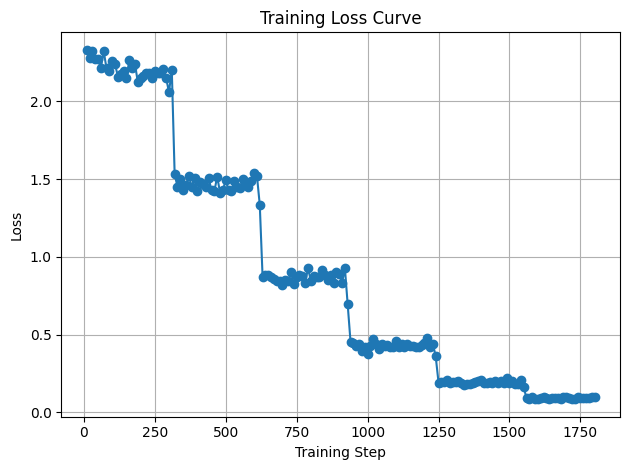

In [1]:
import json
import matplotlib.pyplot as plt

log_training_file = r'C:\Users\franc\Documents\Bridge_the_GAP\data\SFT_training_bgm\meta-llama-Llama-3.2-1B\checkpoint-1800\trainer_state.json'

# Carica il file JSON
with open(log_training_file, "r") as f:
    data = json.load(f)

# Estrai i log
log_history = data["log_history"]

# Filtra solo le entries con "loss"
steps = []
losses = []

for entry in log_history:
    if "loss" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])

# Stampa i valori (opzionale)
for s, l in zip(steps, losses):
    print(f"Step {s}: Loss = {l}")

# Plot della curva della loss
plt.plot(steps, losses, marker='o', linestyle='-')
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.tight_layout()
plt.show()